# Claude Sonnet 3.5 V2 with v2.17 prompt

This notebook outlines the steps undertook to generate a prediction using Claude Sonnet 3.5 V2 with prompt from 2/17/25.

This prompt is built from the v2.14 v2 version by adding additional instructions based on analysis of failed predictions; specifically, additional language is added to emphasize that "overrule" in this context only refers to "overrule" by the Acting Case and not by any other case.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from prediction_utils import predict
from evaluate_predictions import show_metrics

from instructions import claude_instructions_v217
MODEL_ID = "anthropic.claude-3-5-sonnet-20241022-v2:"
SYSTEM_PROMPT = claude_instructions_v217

# Load the data

In [2]:
df = pd.read_csv("data/dataset.csv")
len(df)

1084

# Use the model to generation predictions

In [3]:
%%time
predictions = predict(df, MODEL_ID, SYSTEM_PROMPT)
predictions[:2]

INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 4
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 0
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 2
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-sonnet-20241022-v2:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 3
INFO:httpx:HTT

CPU times: user 48.7 s, sys: 5.89 s, total: 54.6 s
Wall time: 14min 42s


[{'0005.91306_cites_88693.txt': {'model': 'claude-3-5-sonnet-20241022',
   'input_tokens': 2430,
   'output_tokens': 100,
   'prediction': 'no',
   'confidence': 0.95,
   'rationale': "The passage discusses and clarifies the Target Case's holding but does not overrule it. Instead, it explains the scope and limitations of the previous ruling, stating 'we have not held that such a repealing act was absolutely void.' This is a clarification of the prior holding rather than an overruling of it.",
   'raw_results': '{\n  "overruled": "no",\n  "confidence": 0.95,\n  "rationale": "The passage discusses and clarifies the Target Case\'s holding but does not overrule it. Instead, it explains the scope and limitations of the previous ruling, stating \'we have not held that such a repealing act was absolutely void.\' This is a clarification of the prior holding rather than an overruling of it."\n}'}},
 {'0001.91306_cites_88061.txt': {'model': 'claude-3-5-sonnet-20241022',
   'input_tokens': 3261,


In [4]:
prediction_df = pd.DataFrame([
    {"filename": filename, **details} 
    for prediction in predictions 
    for filename, details in prediction.items()
])
prediction_df.head()

,filename,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0005.91306_cites_88693.txt,claude-3-5-sonnet-20241022,2430,100,no,0.95,The passage discusses and clarifies the Target...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
1,0001.91306_cites_88061.txt,claude-3-5-sonnet-20241022,3261,99,yes,0.95,The passage explicitly states that positions t...,"{\n ""overruled"": ""yes"",\n ""confidence"": 0.95..."
2,0003.91306_cites_87633.txt,claude-3-5-sonnet-20241022,2459,105,no,0.95,The passage cites and reaffirms the Target Cas...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
3,0004.91306_cites_88240.txt,claude-3-5-sonnet-20241022,2425,116,no,0.95,The passage discusses the Target Case (Texas v...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
4,0002.91306_cites_88994.txt,claude-3-5-sonnet-20241022,2942,108,no,0.99,The passages discuss and analyze the Target Ca...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.99,..."


## Save the raw prediction results

In [5]:
prediction_df.to_csv("predictions/1.claude/5.sonnet3.5v2_v217_prompt.csv", index=False)

## Check if any datapoints did not get prediction results and need to be re-predicted or cleaned

In [7]:
prediction_df["prediction"].isna().sum()

1

In [8]:
# Here I manually reviewed these cases in Google Sheets and replaced with the cleaned version
prediction_df = pd.read_csv("predictions/1.claude/5.sonnet3.5v2_v217_prompt.csv")

In [9]:
prediction_df["prediction"].isna().sum()

0

# Combine the prediction results with label for evaluation

In [10]:
assert len(df) == len(prediction_df)

In [11]:
eval_df = df.merge(prediction_df, how="left", on="filename")
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-sonnet-20241022,3261,99,yes,0.95,The passage explicitly states that positions t...,"{\n ""overruled"": ""yes"",\n ""confidence"": 0.95..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-sonnet-20241022,2942,108,no,0.99,The passages discuss and analyze the Target Ca...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.99,..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-sonnet-20241022,2459,105,no,0.95,The passage cites and reaffirms the Target Cas...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-sonnet-20241022,2425,116,no,0.95,The passage discusses the Target Case (Texas v...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-sonnet-20241022,2430,100,no,0.95,The passage discusses and clarifies the Target...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."


# Run evaluation

In [12]:
df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [13]:
eval_df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [14]:
eval_df["prediction"].value_counts()

prediction
no     936
yes    148
Name: count, dtype: int64

In [15]:
eval_df["input_tokens"].sum()

3970234

In [16]:
eval_df["output_tokens"].sum()

129905

In [17]:
y_true = eval_df["overruled"].map({"yes": 1, "no": 0})
y_pred = eval_df["prediction"].map({"yes": 1, "no": 0})

In [18]:
report = classification_report(y_true, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.96      0.96      0.96       935
         Yes       0.76      0.76      0.76       149

    accuracy                           0.93      1084
   macro avg       0.86      0.86      0.86      1084
weighted avg       0.93      0.93      0.93      1084



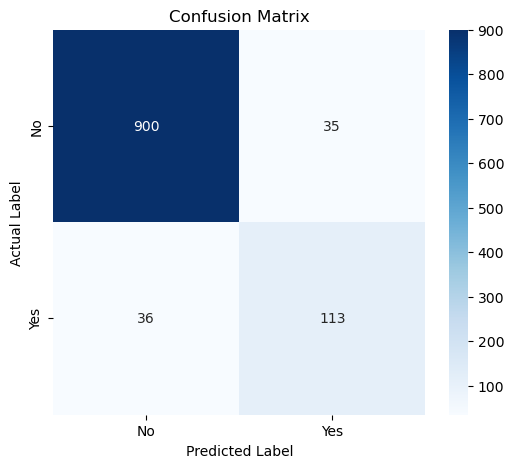

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
show_metrics(cm, y_true)

precision: of all predicted positives, how many were actual positives
recall: of all actual positives, how many we predicted to be positives
---------
METRICS
Accuracy: 0.93
Precision: 0.76
Recall: 0.76
F-score: 0.76
Specificity: 0.96
---------
DATASET
Total Responses: 1084
Total Positives: 149
Total Negatives: 935
---------
RECOUNT
True positives: 113
True negatives: 900
False positives: 35
False negatives: 36


In [21]:
confidently_wrong_positive = (eval_df["prediction"] == "yes") & (eval_df["overruled"] == "no") & (eval_df["confidence"] >= 0.8)
confidently_wrong_positive.sum()

35

In [22]:
confidently_wrong_negative = (eval_df["prediction"] == "no") & (eval_df["overruled"] == "yes") & (eval_df["confidence"] >= 0.8)
confidently_wrong_negative.sum()

36

# Save the evaluation df

In [23]:
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-sonnet-20241022,3261,99,yes,0.95,The passage explicitly states that positions t...,"{\n ""overruled"": ""yes"",\n ""confidence"": 0.95..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-sonnet-20241022,2942,108,no,0.99,The passages discuss and analyze the Target Ca...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.99,..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-sonnet-20241022,2459,105,no,0.95,The passage cites and reaffirms the Target Cas...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-sonnet-20241022,2425,116,no,0.95,The passage discusses the Target Case (Texas v...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-sonnet-20241022,2430,100,no,0.95,The passage discusses and clarifies the Target...,"{\n ""overruled"": ""no"",\n ""confidence"": 0.95,..."


In [24]:
eval_df.to_csv("predictions/1.claude/5.sonnet3.5v2_v217_prompt_eval.csv", index=False)